In [1]:
#下载模型，并解压
#wget https://github.com/mozilla/DeepSpeech/releases/download/v0.1.0/deepspeech-0.1.0-models.tar.gz
#tar xvfz deepspeech-0.1.0-models.tar.gz
import numpy as np
import tensorflow as tf
import argparse
from shutil import copyfile
#没有deepspeech 请先pip install deepspeech
import deepspeech
import scipy.io.wavfile as wav
import wave
import struct
import time
import os
import sys
import matplotlib.pyplot as plt


16193 [16000, 16000, 16000]


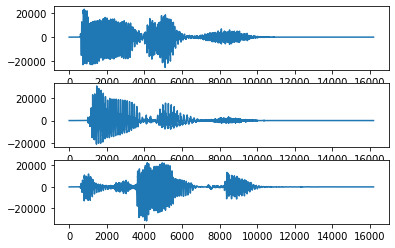

In [2]:
BEAM_WIDTH = 1024
N_FEATURES = 26
N_CONTEXT = 9
modelPath = './models/output_graph.pbmm'
alphabetPath = './models/alphabet.txt'
model = deepspeech.Model(modelPath, N_FEATURES, N_CONTEXT, alphabetPath, BEAM_WIDTH)
#print(model)
LM_ALPHA = 0.75
LM_BETA = 1.85
lmPath = './models/lm.binary'
triePath = './models/trie'
a = model.enableDecoderWithLM(alphabetPath, lmPath, triePath, LM_ALPHA, LM_BETA)
#fin = wave.open('english.wav','rb')

fs1,audios1 = wav.read('english.wav','rb')
fs2,audios2 = wav.read('english2.wav','rb')
fs3,audios3 = wav.read('example.wav','rb')
fs_list = [fs1,fs2,fs3]
audios_list = [list(audios1),list(audios2),list(audios3)]
len_list = [len(audios1),len(audios2),len(audios3)]
maxlen = max(len_list)
audios_list = np.array([x+[0]*(maxlen-len(x)) for x in audios_list])
#fs = fin.getframerate()
#audio = np.frombuffer(fin.readframes(fin.getnframes()), np.int16)
#audio_length = fin.getnframes() * (1/16000)
print(maxlen,fs_list)
#fin.close()
#print(model.stt(audios,fs))
for i in range(len(audios_list)):
    ax = plt.subplot(3,1,i+1)
    ax.plot(audios_list[i])

In [4]:
batch_size = 1
phrase_length = 10
max_audio_len = maxlen
fs =16000
noise = tf.Variable(tf.random_normal((batch_size, max_audio_len), dtype=np.float32), name='delta')
#mask = tf.Variable(tf.random_normal((batch_size, max_audio_len), dtype=np.float32), name='mask')
original = tf.Variable(np.zeros((batch_size, max_audio_len), dtype=np.float32), name='original')
#rescale = tf.Variable(tf.random_normal((batch_size,1), dtype=np.float32), name='rescale')

In [8]:
#在工作目录下创建result文件夹
import os
model_dir = './result/'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [5]:
def speech_attack(audios_list,n,num):    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        #noise = tf.random_normal(mask.shape,stddev=2)
        #apply_delta = tf.clip_by_value(delta*10, -2000, 2000)*rescale
        ans = []
        for i in range(len(audios_list)):
            audios = audios_list[i]
            audio = audios.reshape((1,-1))
            origin = original.assign(np.array(audio))
            new_input =  origin 
            pass_in = tf.clip_by_value(new_input+noise*n, -2**15, 2**15-1)
            result = sess.run(pass_in)
            result = result.reshape((-1,))
            result = result.astype('int16')
            ans.append(model.stt(result,fs))
            path = './result/result_'+ str(num)+'_'+str(i)+'.wav'
            wav.write(path, 16000,np.array(np.clip(np.round(result),-2**15, 2**15-1)))
        print(ans)

In [9]:
for i in range(10):
    speech_attack(audios_list,i*100,i)

['english', 'english', 'example']
['english', 'english', 'example']
['english', 'things', 'example']
['english', 'thinketh', 'example']
['english', 'things is', 'example']
['hinglish', 'things is', 'some of']
['english', 'seems to', 'come for']
['things lest', 'things have', 'he found for']
['things less', 'seems as', 'some']
['in less', 'things are', 'he said for']
